In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from pylab import rcParams

from statsmodels.tsa.seasonal import seasonal_decompose as SDecompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima

pd.options.mode.chained_assignment = None

df = pd.read_csv('/home/jithendra/Documents/SemVII/BA_R/pr2/household_power_consumption.txt', delimiter=';', 
                na_values=['nan','?'], dtype={'Date':str,'Time':str,'Global_active_power':np.float64,
                'Global_reactive_power':np.float64, 'Voltage':np.float64 ,'Global_intensity':np.float64,
                'Sub_metering_1':np.float64, 'Sub_metering_2':np.float64,'Sub_metering_3': np.float64})

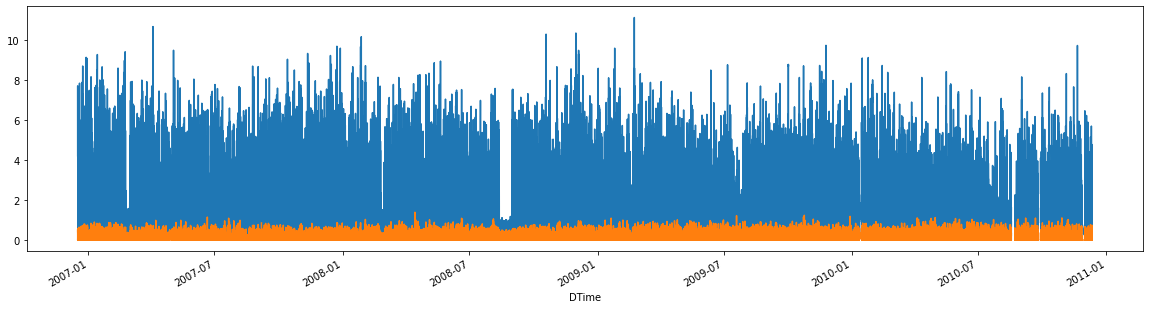

In [2]:
df['DTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.drop(['Date', 'Time'], axis=1)
df = df.set_index('DTime')

df['Global_active_power'].plot(figsize=(20, 5))
df['Global_reactive_power'].plot()
pyplot.show()

In [3]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
sampled_df = df.bfill().resample('W').mean()

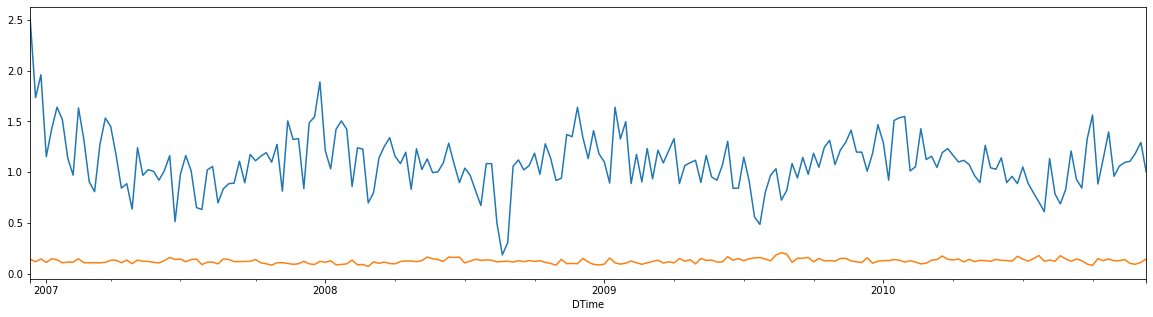

In [5]:
sampled_df['Global_active_power'].plot(figsize=(20, 5))
sampled_df['Global_reactive_power'].plot()
pyplot.show()

In [6]:
print(sampled_df.corr())

                       Global_active_power  Global_reactive_power   Voltage  \
Global_active_power               1.000000              -0.225006  0.246474   
Global_reactive_power            -0.225006               1.000000  0.008691   
Voltage                           0.246474               0.008691  1.000000   
Global_intensity                  0.999110              -0.209269  0.216768   
Sub_metering_1                    0.495170               0.058062 -0.059287   
Sub_metering_2                    0.503331               0.020971 -0.139848   
Sub_metering_3                    0.740692              -0.080985  0.376264   

                       Global_intensity  Sub_metering_1  Sub_metering_2  \
Global_active_power            0.999110        0.495170        0.503331   
Global_reactive_power         -0.209269        0.058062        0.020971   
Voltage                        0.216768       -0.059287       -0.139848   
Global_intensity               1.000000        0.507210        0.51

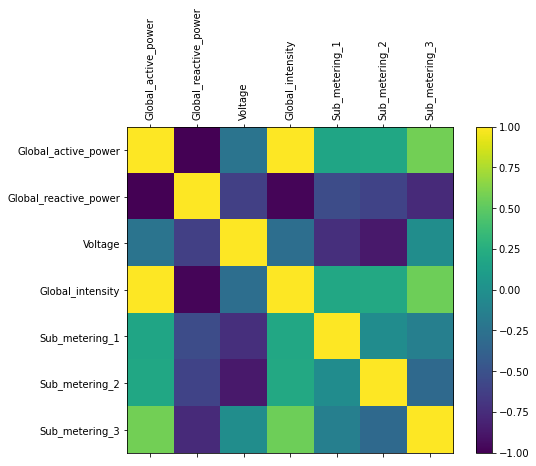

In [7]:
import matplotlib.pyplot as plt
corr = sampled_df.corr()
fig, ax = plt.subplots(figsize=(8, 6))
cax=ax.matshow(corr,vmin=-1,vmax=1)
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.xticks(rotation=90)
plt.colorbar(cax)

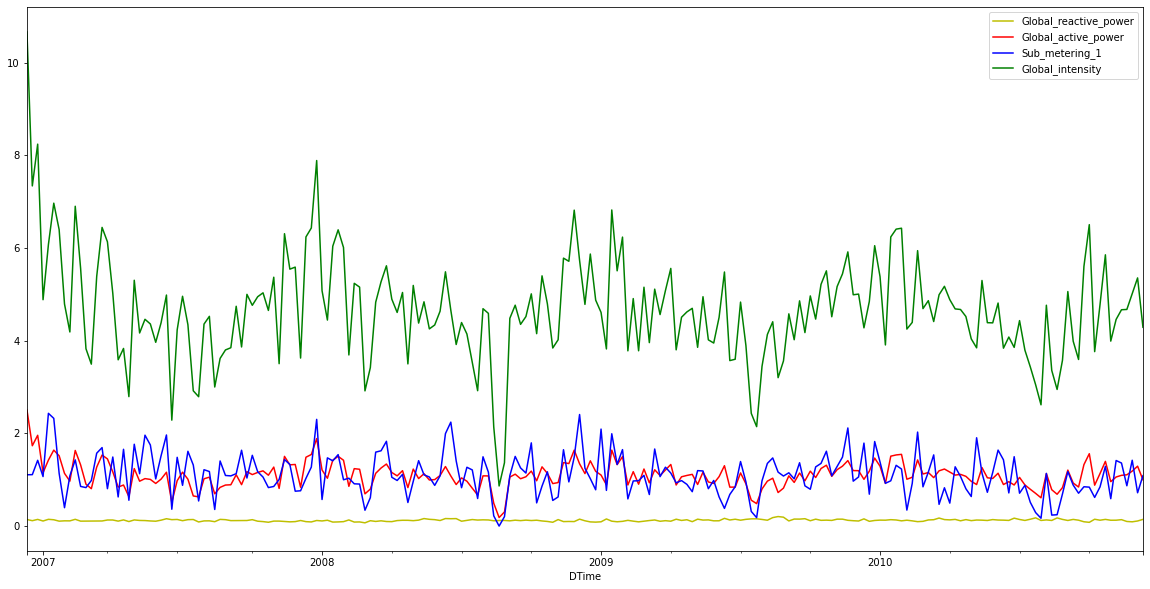

In [8]:
sampled_df.Global_reactive_power.plot(figsize=(20, 10), color='y', legend=True)
sampled_df.Global_active_power.plot(color='r', legend=True)
sampled_df.Sub_metering_1.plot(color='b', legend=True)
sampled_df.Global_intensity.plot(color='g', legend=True)
pyplot.show()

### Seasonality and Stationarity

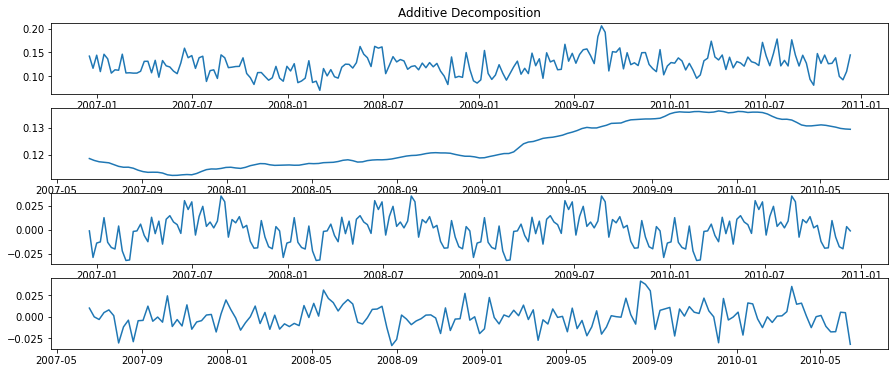

In [17]:
rcParams['figure.figsize'] = 15, 6

fig, axes = pyplot.subplots(4, 1)

add_decomposition = SDecompose(sampled_df.Global_reactive_power, model='additive')


axes[0].plot(add_decomposition.observed)
axes[0].set_title("Additive Decomposition")
axes[1].plot(add_decomposition.trend)
axes[2].plot(add_decomposition.seasonal)
axes[3].plot(add_decomposition.resid)
pyplot.show()

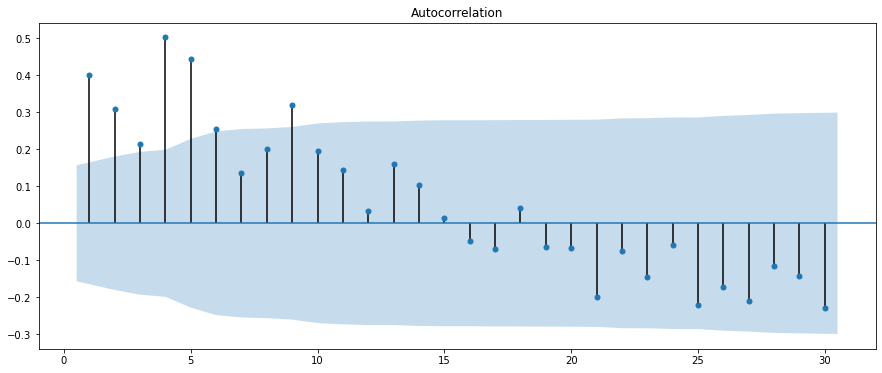

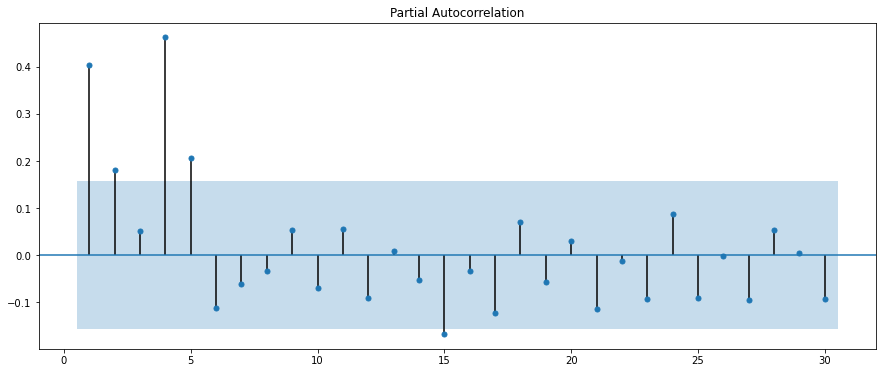

In [18]:
split = int(0.75 * len(sampled_df))
sampled_train, sampled_test = sampled_df[:split], sampled_df[split:]

plot_acf(sampled_train.Global_reactive_power, lags=30, zero=False)
plot_pacf(sampled_train.Global_reactive_power, lags=30, zero=False)

pyplot.show()

In [19]:
print(adfuller(sampled_train.Global_reactive_power))

shifted_power = sampled_train.Global_reactive_power.diff(1)[1:]

print(adfuller(shifted_power))

(-2.19378857440425, 0.20850756522419361, 4, 151, {'1%': -3.4744158894942156, '5%': -2.880878382771059, '10%': -2.577081275821236}, -720.4309785134178)
(-12.041946448376011, 2.719343055723341e-22, 3, 151, {'1%': -3.4744158894942156, '5%': -2.880878382771059, '10%': -2.577081275821236}, -713.0565630849914)


### Creating SARIMA models

Now we can start modeling by using a basic SARIMA model that uses (1, 1, 1), (1, 1, 1, 7) as (p, d, q)(P, D, Q, s) parameters respectively.

In [20]:
params, seasonal_params = (1, 1, 1), (1, 0, 1, 7)

mod = SARIMAX(sampled_train.Global_reactive_power, order=params, seasonal_order=seasonal_params, 
              enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:             Global_reactive_power   No. Observations:                  156
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood                 368.347
Date:                           Thu, 03 Dec 2020   AIC                           -726.693
Time:                                   11:33:27   BIC                           -711.775
Sample:                               12-17-2006   HQIC                          -720.632
                                    - 12-06-2009                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0147      0.126      0.117      0.907      -0.232       0.261
ma.L1         -0.7438      0.073    -10.168      0.000      -0.887      -0.600
ar.S.L7        0.4561      0.181      2.520      0.012       0.101       0.811
ma.S.L7       -0.7553      0.165     -4.582      0.000      -1.078      -0.432
sigma2         0.0004   4.12e-05      8.774      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       57.94   Jarque-Bera (JB):                 3.14
Prob(Q):                              0.03   Prob(JB):                         0.21
Heteroskedasticity (H):               1.85   Skew:                             0.30
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
model_auto = auto_arima(sampled_train.Global_reactive_power, max_order=None, max_p=4, max_q=10, max_P=4, max_Q=10, 
                max_D=1, m=7, alpha=0.05, trend='t', information_criteria='oob', out_of_sample=int(0.02*len(sampled_train)),
                maxiter=200, suppress_warnings=True)

model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  156
Model:             SARIMAX(0, 1, 2)x(0, 0, [1], 7)   Log Likelihood                 388.655
Date:                             Thu, 03 Dec 2020   AIC                           -767.309
Time:                                     12:20:24   BIC                           -752.092
Sample:                                          0   HQIC                          -761.129
                                             - 156                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       7.918e-07   4.47e-06      0.177      0.859   -7.97e-06    9.55e-06
ma.L1         -0.7122      0.092     -7.756      0.000      -0.892      -0.532
ma.L2         -0.0122      0.109     -0.112      0.911      -0.226       0.201
ma.S.L7       -0.2362      0.098     -2.421      0.015      -0.427      -0.045
sigma2         0.0004   6.35e-05      6.941      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       66.81   Jarque-Bera (JB):                 2.54
Prob(Q):                              0.00   Prob(JB):                         0.28
Heteroskedasticity (H):               1.72   Skew:                             0.31
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
model_auto = auto_arima(sampled_train.Global_reactive_power, exogenous=sampled_train[['Global_intensity', 'Sub_metering_1',  
                'Sub_metering_2', 'Sub_metering_3', 'Voltage']], max_order=None, max_p=4, max_q=10, max_P=4, max_Q=10, 
                max_D=1, m=7, alpha=0.05, trend=None, information_criteria='oob', out_of_sample=int(0.02*len(sampled_train)),
                maxiter=200, suppress_warnings=True)

model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  156
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 397.141
Date:                Thu, 03 Dec 2020   AIC                           -778.282
Time:                        12:22:13   BIC                           -753.884
Sample:                    12-17-2006   HQIC                          -768.373
                         - 12-06-2009                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Global_intensity    -0.0143      0.002     -7.241      0.000      -0.018      -0.010
Sub_metering_1       0.0155      0.004      4.303      0.000       0.008       0.023
Sub_metering_2       0.0072      0.004      1.935      0.053   -9.16e-05       0.014
Sub_metering_3       0.0065      0.001      4.595      0.000       0.004       0.009
Voltage              0.0005   2.92e-05     17.192      0.000       0.000       0.001
ar.L1                0.2677      0.062      4.295      0.000       0.146       0.390
ar.L2                0.1835      0.070      2.618      0.009       0.046       0.321
sigma2               0.0003    3.7e-05      8.989      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       85.13   Jarque-Bera (JB):                23.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                             0.79
Prob(H) (two-sided):                  0.27   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

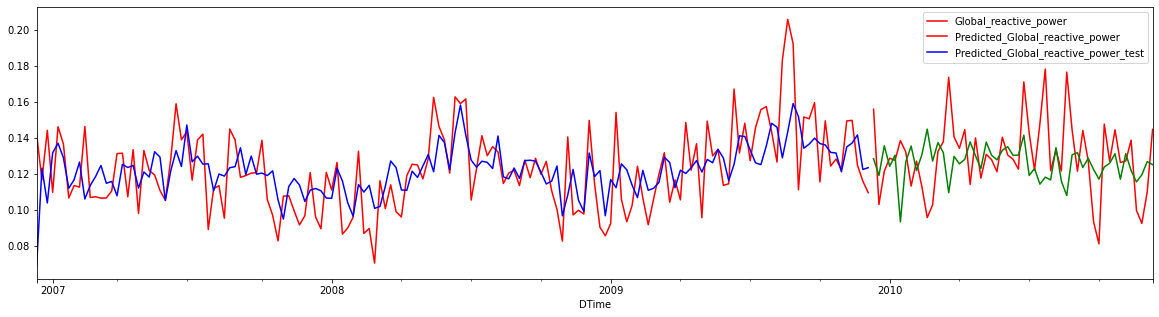

In [36]:
sampled_train['Predicted_Global_reactive_power'] = pd.DataFrame(model_auto.predict_in_sample(exogenous=
    sampled_train[['Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Voltage']]), 
    index = sampled_train.Global_reactive_power.index, columns=['Global_reactive_power'])
sampled_test['Predicted_Global_reactive_power_test'] = pd.DataFrame(model_auto.predict(n_periods=53, exogenous=
    sampled_test[['Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Voltage']]), 
     index = sampled_test.Global_reactive_power.index, columns=['Global_reactive_power'])

ax = sampled_train.Global_reactive_power.plot(figsize=(20, 5), color='red', legend=True)
sampled_test.Global_reactive_power.plot(ax=ax, color='red')

sampled_train['Predicted_Global_reactive_power'].plot(color='blue', ax=ax, legend=True)
sampled_test['Predicted_Global_reactive_power_test'].plot(color='green', ax=ax, legend=True)

pyplot.show()

In [29]:
ax = sampled_test['Predicted_Global_reactive_power_test'].plot(color='green', ax=ax, legend=True)
sampled_test.Global_reactive_power.plot(ax=ax, color='red')
pyplot.show()